In [358]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow
import keras
import seaborn as sns

In [847]:
f1=pd.read_csv("final_raw_to_use.csv")

In [848]:
from cmath import nan


f1=f1.replace(-99,nan)
f1=f1.replace(99,nan)

In [849]:
f1 = f1[f1.isnull().sum(axis=1) < 5] # taking only objects for which less than 5 band flux is unknown

In [850]:
f1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31870 entries, 0 to 38426
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            31870 non-null  int64  
 1   f365w         24047 non-null  float64
 2   f396w         25543 non-null  float64
 3   f427w         30096 non-null  float64
 4   f458w         27761 non-null  float64
 5   f489w         31639 non-null  float64
 6   f520w         31639 non-null  float64
 7   f551w         29805 non-null  float64
 8   f582w         31564 non-null  float64
 9   f613w         31370 non-null  float64
 10  f644w         31713 non-null  float64
 11  f675w         31767 non-null  float64
 12  f706w         31860 non-null  float64
 13  f737w         31855 non-null  float64
 14  f768w         31756 non-null  float64
 15  f799w         31699 non-null  float64
 16  f830w         31432 non-null  float64
 17  f861w         31674 non-null  float64
 18  f892w         29961 non-nu

In [851]:
f1.fillna(f1.median().round(3), inplace=True)

In [852]:
f1.columns

Index(['id', 'f365w', 'f396w', 'f427w', 'f458w', 'f489w', 'f520w', 'f551w',
       'f582w', 'f613w', 'f644w', 'f675w', 'f706w', 'f737w', 'f768w', 'f799w',
       'f830w', 'f861w', 'f892w', 'f923w', 'f954w', 'j', 'h', 'ks', 'f814w',
       'fwhm', 'stellar_flag', 'g/s'],
      dtype='object')

In [853]:
len(f1[(f1["f814w"]<=22.5) & (f1["g/s"]==0)])

5999

In [854]:
len(f1[(f1["f814w"]<=26) & (f1["g/s"]==1)])

2247

In [855]:
len(f1[((f1["f814w"]>24)&(f1["f814w"]<=25)) & (f1["g/s"]==1)])

101

In [856]:
len(f1[(f1["f814w"]<=26) & (f1["g/s"]==0)])

29615

In [812]:
f2=f1.copy(deep=True)
f2=f2[f2['f814w']<=22.5]

X=f2.drop(["id",'g/s','stellar_flag'],axis=1)
y=f2['g/s']

In [631]:
len(y[y==1]) # no. of stars

1764

# checking best performing model 

# XGBOOST

In [515]:
import xgboost
from xgboost import XGBClassifier as xgc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [516]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

In [291]:
param_grid={
    'n_estimators':[80,100,120],
    'max_depth':[4,6,8],
    'learning_rate':[0.01,0.1,0.3],
    'gamma':[0,0.01,0.2],
    'scale_pos_weight':[1,3.5],
    'reg_alpha':[0,1,5,10]
}

cv=GridSearchCV(estimator=xgc(),param_grid=param_grid,cv=5,n_jobs=-1)
cv.fit(x_train,y_train)
print(cv.best_params_)

{'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 80, 'reg_alpha': 0, 'scale_pos_weight': 1}


In [299]:
XGC=xgc(gamma= 0.2, learning_rate= 0.3, max_depth= 4, n_estimators =80, reg_alpha= 1, scale_pos_weight= 1)
XGC.fit(x_train,y_train)
predict=XGC.predict_proba(x_test)

predict=pd.DataFrame(data=predict)
predict=predict[1].values
auc_score=roc_auc_score(y_test,predict)
auc_score

0.9956435873605949

for different features, f814w<=22.5

In [579]:
score_xg=[]
predicted_class_xg=[]

for i in (0,3,4,5):
    if i==0: 
        k=3
    else: 
        k=5

    x_train_new=x_train.iloc[:,0:20+i]
    x_test_new=x_test.iloc[:,0:20+i]
    
    
    XGC=xgc(gamma= 0.2, learning_rate= 0.3, max_depth= 6, n_estimators =80, reg_alpha= 1, scale_pos_weight= 1)
    XGC.fit(x_train_new,y_train)
    predict=XGC.predict_proba(x_test_new)
    predict=pd.DataFrame(data=predict)
    predict=predict[1].values
   

    score_xg.append(roc_auc_score(y_test,predict))
    predict=pd.DataFrame(predict,columns=['pred_class']) 
    predict.loc[predict["pred_class"]<0.5, "pred_class"] = 0
    predict.loc[predict["pred_class"]>0.5, "pred_class"] = 1
    predicted_class_xg.append(predict)

In [580]:
score_xg

[0.9697664962825278,
 0.9837028677642061,
 0.9838854221986192,
 0.9943657063197026]

for different ranges

In [306]:
score_814_xg=[]
FPS_rate_xg=[]
TPS_rate_xg=[]

for i,j in zip([22.5,23,24,25,26],[0,22.5,23,24,0]):
    
    f5=f1.copy()
    f5=f5[(f5['f814w']<=i)&(f5['f814w']>j)]

    X=f5.drop(["id",'g/s','stellar_flag'],axis=1)
    y=f5['g/s']
    
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

    XGC=xgc(gamma= 0.2, learning_rate= 0.3, max_depth= 4, n_estimators =80, reg_alpha= 1, scale_pos_weight= 1)
    XGC.fit(x_train,y_train)
    predict=XGC.predict_proba(x_test)
    predict=pd.DataFrame(data=predict)
    predict=predict[1].values
    
    score_814_xg.append(roc_auc_score(y_test,predict))
    false_positive_rate,true_positive_rate,thresholds= roc_curve(y_test,predict) 
    FPS_rate_xg.append(false_positive_rate)
    TPS_rate_xg.append(true_positive_rate)

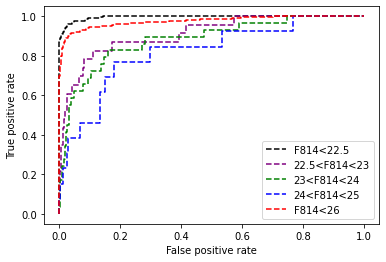

In [307]:
result=pd.DataFrame({'F814':["F814<22.5","22.5<F814<23","23<F814<24","24<F814<25","F814<26"],'AUC score':score_814_xg})
plt.plot(FPS_rate_xg[0],TPS_rate_xg[0],color="black",alpha=1,ls='dashed',label="F814<22.5")
plt.plot(FPS_rate_xg[1],TPS_rate_xg[1],color="purple",alpha=1,ls='dashed',label="22.5<F814<23")
plt.plot(FPS_rate_xg[2],TPS_rate_xg[2],color="green",alpha=1,ls='dashed',label="23<F814<24")
plt.plot(FPS_rate_xg[3],TPS_rate_xg[3],color="blue",alpha=1,ls='dashed',label="24<F814<25")
plt.plot(FPS_rate_xg[4],TPS_rate_xg[4],color="red",alpha=1,ls='dashed',label="F814<26")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.legend()
plt.show()

In [308]:
result

,F814,AUC score
0,F814<22.5,0.995644
1,22.5<F814<23,0.909787
2,23<F814<24,0.881833
3,24<F814<25,0.820495
4,F814<26,0.975592


## ANN

In [372]:
from keras.layers import Dense, Activation,Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from keras.layers import BatchNormalization
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [596]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

In [597]:
def ANN(no_of_neurons,no_of_layers,dropout,activation,learning_rate):   # difining neural net
    model=Sequential()
    model.add(Dense(no_of_neurons,input_dim=x_train.shape[1],activation=activation))
    model.add(BatchNormalization())
    for i in range(no_of_layers):
     model.add(Dense(no_of_neurons,activation))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate=learning_rate),metrics=["accuracy"])
    return model

In [598]:
def plot_training(training):               # function to check overfitting via graph
    acc_values = training['accuracy']
    val_acc_values = training['val_accuracy']
    epochs = range(1, len(acc_values) + 1)

    plt.plot(epochs, acc_values, 'bo', label='Training acc',)
    plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
    
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [351]:
test_model=KerasClassifier(build_fn=ANN)    # hyperparameterizing defined neural net
param_grid={
    'no_of_neurons':[25,40,75],
    'no_of_layers':[2,3,4],
    'dropout':[0.3,0.5,0.7],
    "activation":['relu','LeakyRelu'],
    "learning_rate":[0.003]
}

cv=GridSearchCV(estimator=test_model,param_grid=param_grid,cv=3,n_jobs=-1)
cv.fit(x_train,y_train)
print(cv.best_params_)

/tmp/ipykernel_637147/2137459607.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  test_model=KerasClassifier(build_fn=ANN)    # hyperparameterizing defined neural net
2022-11-12 20:12:40.423595: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-12 20:12:40.423595: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-12 20:12:40.423597: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or d

69/69 [==============================] - 0s 1ms/step - loss: 0.9001 - accuracy: 0.7945


/home/pratyaksh/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
81 fits failed out of a total of 162.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pratyaksh/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pratyaksh/.local/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/pratyaksh/.local/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 155, in fit
    self.mo

207/207 [==============================] - 1s 2ms/step - loss: 0.2750 - accuracy: 0.8954
{'activation': 'relu', 'dropout': 0.3, 'learning_rate': 0.003, 'no_of_layers': 2, 'no_of_neurons': 40}


In [599]:
model=ANN(no_of_neurons=40,no_of_layers=2,activation='relu',learning_rate=0.003,dropout=0.3)

In [600]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping               # for getting the best accuracy in all epoches

checkpoint= ModelCheckpoint("model_checkpoint.h5",save_best_only=True)
early_stopping = EarlyStopping( patience=200, restore_best_weights=True)

In [601]:
training_history=model.fit(x_train,y_train,epochs=500,batch_size=500,verbose=0,validation_data=[x_test,y_test],callbacks=[checkpoint,early_stopping])

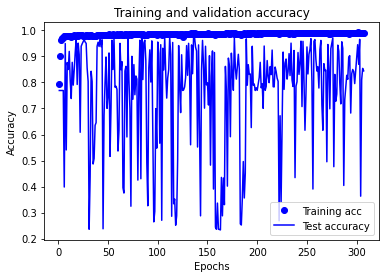

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [602]:
training_info=training_history.history
plot_training(training_info)
training_info.keys()

we can see its highly prone to overfitting

auc score

In [603]:
predict=model.predict(x_test)
auc_score=roc_auc_score(y_test,predict)
auc_score

37/37 [==============================] - 0s 1ms/step


0.9935068706850769

now classifying by gradually adding features.Starting from 20 optical bands 

In [610]:
score_ann=[]
predicted_class_ann=[]

for i in (0,3,4,5):
    if i==0: 
        k=3
    else: 
        k=5

    x_train_new=x_train.iloc[:,0:20+i]
    x_test_new=x_test.iloc[:,0:20+i]
    
    
    model=Sequential()
    model.add(Dense(30,input_dim=x_train_new.shape[1],activation='relu'))
    model.add(BatchNormalization())
    for i in range(2):
     model.add(Dense(30,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate=0.003),metrics=["accuracy"])
    
    checkpoint= ModelCheckpoint("model_checkpoint.h5",save_best_only=True)
    early_stopping = EarlyStopping( patience=200, restore_best_weights=True)
   
    model.fit(x_train_new,y_train,epochs=500,batch_size=500,verbose=0,validation_data=[x_test_new,y_test],callbacks=[checkpoint,early_stopping])

    predict=model.predict(x_test_new)
    score_ann.append(roc_auc_score(y_test,predict))
    predict=pd.DataFrame(predict,columns=['pred_class']) 
    predict.loc[predict["pred_class"]<0.5, "pred_class"] = 0
    predict.loc[predict["pred_class"]>0.5, "pred_class"] = 1
    predicted_class_ann.append(predict)

37/37 [==============================] - 0s 2ms/step


In [611]:
score_ann

[0.9532121282527881, 0.9747037639405204, 0.982823287307488, 0.9917809014869888]

In [378]:
score_814_ann=[]
FPS_rate_ann=[]
TPS_rate_ann=[]

for i,j in zip([22.5,23,24,25,26],[0,22.5,23,24,0]):
    
    f5=f1.copy()
    f5=f5[(f5['f814w']<=i)&(f5['f814w']>j)]

    X=f5.drop(["id",'g/s','stellar_flag'],axis=1)
    y=f5['g/s']
    
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)
    
    model=ANN(no_of_neurons=25,no_of_layers=2,activation='relu',learning_rate=0.003,dropout=0.5)
    
    training_history=model.fit(x_train,y_train,epochs=500,batch_size=500,verbose=0,validation_data=[x_test,y_test],callbacks=[checkpoint,early_stopping])
    
    

    predict=model.predict(x_test)
    score_814_ann.append(roc_auc_score(y_test,predict))
    false_positive_rate,true_positive_rate,thresholds= roc_curve(y_test,predict) 
    FPS_rate_ann.append(false_positive_rate)
    TPS_rate_ann.append(true_positive_rate)

150/150 [==============================] - 0s 1ms/step


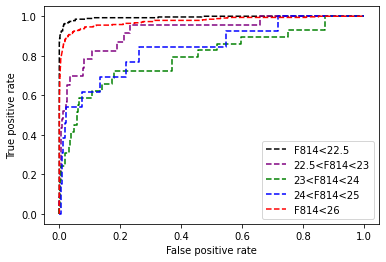

In [379]:
result=pd.DataFrame({'F814':["F814<22.5","22.5<F814<23","23<F814<24","24<F814<25","F814<26"],'AUC score':score_814_ann})
plt.plot(FPS_rate_ann[0],TPS_rate_ann[0],color="black",alpha=1,ls='dashed',label="F814<22.5")
plt.plot(FPS_rate_ann[1],TPS_rate_ann[1],color="purple",alpha=1,ls='dashed',label="22.5<F814<23")
plt.plot(FPS_rate_ann[2],TPS_rate_ann[2],color="green",alpha=1,ls='dashed',label="23<F814<24")
plt.plot(FPS_rate_ann[3],TPS_rate_ann[3],color="blue",alpha=1,ls='dashed',label="24<F814<25")
plt.plot(FPS_rate_ann[4],TPS_rate_ann[4],color="red",alpha=1,ls='dashed',label="F814<26")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.legend()
plt.show()

In [380]:
result

,F814,AUC score
0,F814<22.5,0.994816
1,22.5<F814<23,0.925206
2,23<F814<24,0.797953
3,24<F814<25,0.842582
4,F814<26,0.975812


# RANDOMFOREST

In [381]:
from sklearn.ensemble import RandomForestClassifier

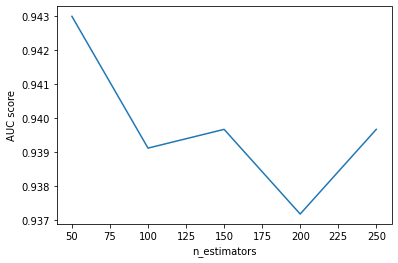

In [46]:
n_estimators=[50,100,150,200,250]      # getting best no. of trees 
test_area=[]
for estimator in n_estimators:
    rf=RandomForestClassifier(n_estimators=estimator,n_jobs=-1)
    rf.fit(x_train,y_train)
    predict=rf.predict(x_test)
    roc_auc=roc_auc_score(y_test,predict)
    test_area.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line=plt.plot(n_estimators,test_area)
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()


In [51]:
param_grid={
    'n_estimators':[50,100,200],
    'min_samples_split':[2,4]
}

cv=GridSearchCV(estimator=RandomForestClassifier(),param_grid=param_grid,cv=5,n_jobs=-1)
cv.fit(x_train,y_train)
print(cv.best_params_)

{'min_samples_split': 2, 'n_estimators': 200}


In [387]:
rf=RandomForestClassifier(n_estimators=200,min_samples_split=2,n_jobs=-1)
rf.fit(x_train,y_train)
predict=rf.predict_proba(x_test)

In [388]:
predict=pd.DataFrame(data=predict)
predict=predict[1].values

auc score

In [389]:
auc_score=roc_auc_score(y_test,predict)
auc_score

0.9902229653478493

running while gradually adding features

In [390]:
score_rf=[]
predicted_class_rf=[]

for i in (0,3,4,5):
    if i==0: 
        k=3
    else: 
        k=5

    x_train_new=x_train.iloc[:,0:20+i]
    x_test_new=x_test.iloc[:,0:20+i]
    
    
    rf=RandomForestClassifier(n_estimators=150+10*i,min_samples_split=2,n_jobs=-1)
    rf.fit(x_train_new,y_train)
    predict=rf.predict_proba(x_test_new)
    predict=pd.DataFrame(data=predict)
    predict=predict[1].values
   

    score_rf.append(roc_auc_score(y_test,predict))
    predict=pd.DataFrame(predict,columns=['pred_class']) 
    predict.loc[predict["pred_class"]<0.5, "pred_class"] = 0
    predict.loc[predict["pred_class"]>0.5, "pred_class"] = 1
    predicted_class_rf.append(predict)

In [391]:
score_rf

[0.9572656664896442, 0.980848380244291, 0.9806492299522038, 0.992963356346256]

In [392]:
score_814_rf=[]
FPS_rate_rf=[]
TPS_rate_rf=[]

for i,j in zip([22.5,23,24,25,26],[0,22.5,23,24,0]):
    
    f5=f1.copy()
    f5=f5[(f5['f814w']<=i)&(f5['f814w']>j)]

    X=f5.drop(["id",'g/s','stellar_flag'],axis=1)
    y=f5['g/s']
    
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

    rf=RandomForestClassifier(min_samples_split=2,n_jobs=-1)
    rf.fit(x_train,y_train)
    predict=rf.predict_proba(x_test)
    predict=pd.DataFrame(data=predict)
    predict=predict[1].values
    
    score_814_rf.append(roc_auc_score(y_test,predict))
    false_positive_rate,true_positive_rate,thresholds= roc_curve(y_test,predict) 
    FPS_rate_rf.append(false_positive_rate)
    TPS_rate_rf.append(true_positive_rate)

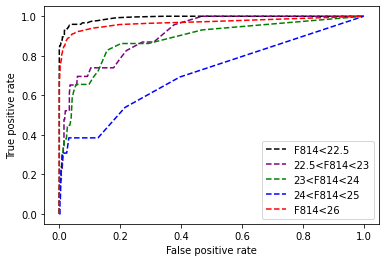

In [393]:
result=pd.DataFrame({'F814':["F814<22.5","22.5<F814<23","23<F814<24","24<F814<25","F814<26"],'AUC score':score_814_rf})
plt.plot(FPS_rate_rf[0],TPS_rate_rf[0],color="black",alpha=1,ls='dashed',label="F814<22.5")
plt.plot(FPS_rate_rf[1],TPS_rate_rf[1],color="purple",alpha=1,ls='dashed',label="22.5<F814<23")
plt.plot(FPS_rate_rf[2],TPS_rate_rf[2],color="green",alpha=1,ls='dashed',label="23<F814<24")
plt.plot(FPS_rate_rf[3],TPS_rate_rf[3],color="blue",alpha=1,ls='dashed',label="24<F814<25")
plt.plot(FPS_rate_rf[4],TPS_rate_rf[4],color="red",alpha=1,ls='dashed',label="F814<26")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.legend()
plt.show()

In [394]:
result

,F814,AUC score
0,F814<22.5,0.992316
1,22.5<F814<23,0.907824
2,23<F814<24,0.881747
3,24<F814<25,0.708132
4,F814<26,0.967374


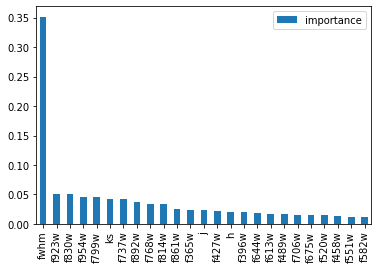

In [395]:
X=f1.drop(["id",'g/s','stellar_flag'],axis=1)
y=f1['g/s']
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

rf=RandomForestClassifier(min_samples_split=2,n_jobs=-1).fit(x_train,y_train)
feature_importances = pd.DataFrame(rf.feature_importances_, index =x_train.columns,  columns=['importance']).sort_values('importance', ascending=False)
feature_importances.plot.bar()    # plotting ranking based on their importance   
plt.show()

# CNN

In [398]:
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense, Activation,Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from keras.layers import BatchNormalization
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


In [499]:
X=f2.drop(["id",'g/s','stellar_flag'],axis=1).values
y=f2['g/s'].values

In [502]:
X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

In [503]:
x_test.shape

(1165, 25)

In [504]:
x_train.shape

(6598, 25)

In [505]:
trainX = x_train.reshape(6598,25,1)           
x_train = trainX / 255.0
testX = x_test.reshape(1165,25,1)
x_test = testX / 255.0

In [478]:
model=Sequential()
model.add(Convolution2D(16,kernel_size=(5, 1), input_shape=(25,1,1),activation= 'LeakyReLU' ))
model.add(MaxPool2D(pool_size=(3,1)))
model.add(Convolution2D(32,kernel_size=(3, 1),activation= 'LeakyReLU' ))
model.add(MaxPool2D(pool_size=(2,1)))
model.add(Convolution2D(64,kernel_size=(2, 1),activation= 'LeakyReLU' ))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate=0.03),metrics=["accuracy"])


In [479]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

checkpoint= ModelCheckpoint("model_checkpoint.h5",save_best_only=True)
early_stopping = EarlyStopping( patience=250, restore_best_weights=True)

In [480]:
training_history=model.fit(x_train,y_train,epochs=1000,batch_size=500,verbose=0,validation_data=[x_test,y_test],callbacks=[checkpoint,early_stopping])

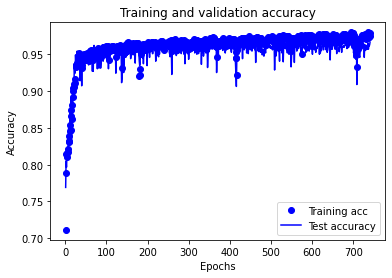

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [481]:
training_info=training_history.history
plot_training(training_info)
training_info.keys()

In [482]:
predict=model.predict(x_test)

37/37 [==============================] - 0s 1ms/step


auc score

In [483]:
auc_score=roc_auc_score(y_test,predict)
auc_score

0.9889513077535846

In [484]:
predict=pd.DataFrame(predict,columns=['pred_class'])

predict.loc[predict["pred_class"]<0.5, "pred_class"] = 0
predict.loc[predict["pred_class"]>0.5, "pred_class"] = 1

# Ada Boost

In [433]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier

In [446]:
X=f2.drop(["id",'g/s','stellar_flag'],axis=1)
y=f2['g/s']

In [447]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

In [437]:
param_grid={
    'n_estimators':[10,50,100],
    'base_estimator':[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=4)]
}
CV_etr = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, cv=5,n_jobs=-1)
CV_etr.fit(x_train, y_train)
print(CV_etr.best_params_)

{'base_estimator': DecisionTreeClassifier(max_depth=4), 'n_estimators': 100}


In [438]:
ada=AdaBoostClassifier(n_estimators=100,base_estimator=(DecisionTreeClassifier(max_depth=4)) )
ada.fit(x_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                   n_estimators=100)

In [439]:
predict=ada.predict_proba(x_test)

In [440]:
predict=pd.DataFrame(data=predict)
predict=predict[1].values

auc

In [441]:
auc_score=roc_auc_score(y_test,predict)
auc_score

0.9927476101964949

running while adding features

In [444]:
score_ada=[]
predicted_class_ada=[]

for i in (0,3,4,5):
    if i==0: 
        k=3
    else: 
        k=5

    x_train_new=x_train.iloc[:,0:20+i]
    x_test_new=x_test.iloc[:,0:20+i]
    
    
    ada=AdaBoostClassifier(n_estimators=50+10*i,base_estimator=(DecisionTreeClassifier(max_depth=4)) )
    ada.fit(x_train_new,y_train)

    predict=ada.predict_proba(x_test_new)
   
    predict=pd.DataFrame(data=predict)
    predict=predict[1].values

    score_ada.append(roc_auc_score(y_test,predict))
    predict=pd.DataFrame(predict,columns=['pred_class']) 
    predict.loc[predict["pred_class"]<0.5, "pred_class"] = 0
    predict.loc[predict["pred_class"]>0.5, "pred_class"] = 1
    predicted_class_ada.append(predict)

In [445]:
score_ada

[0.9179106644981415, 0.9662481744556559, 0.9699075610727562, 0.993386550716941]

In [448]:
score_814_ada=[]
FPS_rate_ada=[]
TPS_rate_ada=[]

for i,j in zip([22.5,23,24,25,26],[0,22.5,23,24,0]):
    
    f5=f1.copy()
    f5=f5[(f5['f814w']<=i)&(f5['f814w']>j)]

    X=f5.drop(["id",'g/s','stellar_flag'],axis=1)
    y=f5['g/s']
    
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

    ada=AdaBoostClassifier(base_estimator=(DecisionTreeClassifier(max_depth=4)))
    ada.fit(x_train,y_train)
   
    predict=ada.predict_proba(x_test)
    predict=pd.DataFrame(data=predict)
    predict=predict[1].values
    
    score_814_ada.append(roc_auc_score(y_test,predict))
    false_positive_rate,true_positive_rate,thresholds= roc_curve(y_test,predict) 
    FPS_rate_ada.append(false_positive_rate)
    TPS_rate_ada.append(true_positive_rate)

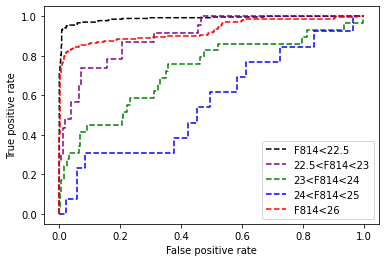

In [449]:
result=pd.DataFrame({'F814':["F814<22.5","22.5<F814<23","23<F814<24","24<F814<25","F814<26"],'AUC score':score_814_ada})
plt.plot(FPS_rate_ada[0],TPS_rate_ada[0],color="black",alpha=1,ls='dashed',label="F814<22.5")
plt.plot(FPS_rate_ada[1],TPS_rate_ada[1],color="purple",alpha=1,ls='dashed',label="22.5<F814<23")
plt.plot(FPS_rate_ada[2],TPS_rate_ada[2],color="green",alpha=1,ls='dashed',label="23<F814<24")
plt.plot(FPS_rate_ada[3],TPS_rate_ada[3],color="blue",alpha=1,ls='dashed',label="24<F814<25")
plt.plot(FPS_rate_ada[4],TPS_rate_ada[4],color="red",alpha=1,ls='dashed',label="F814<26")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.legend()
plt.show()

In [450]:
result

,F814,AUC score
0,F814<22.5,0.989036
1,22.5<F814<23,0.903946
2,23<F814<24,0.725868
3,24<F814<25,0.561868
4,F814<26,0.929579


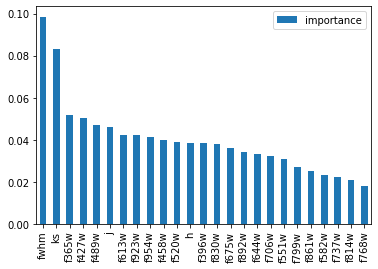

In [451]:
X=f1.drop(["id",'g/s','stellar_flag'],axis=1)
y=f1['g/s']
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

ada=AdaBoostClassifier(n_estimators=100,base_estimator=(DecisionTreeClassifier(max_depth=4))).fit(x_train,y_train)
feature_importances = pd.DataFrame(ada.feature_importances_, index =x_train.columns,  columns=['importance']).sort_values('importance', ascending=False)
feature_importances.plot.bar()    # plotting ranking based on their importance   
plt.show()

# correlation heatmap and feature reduction

<AxesSubplot:>

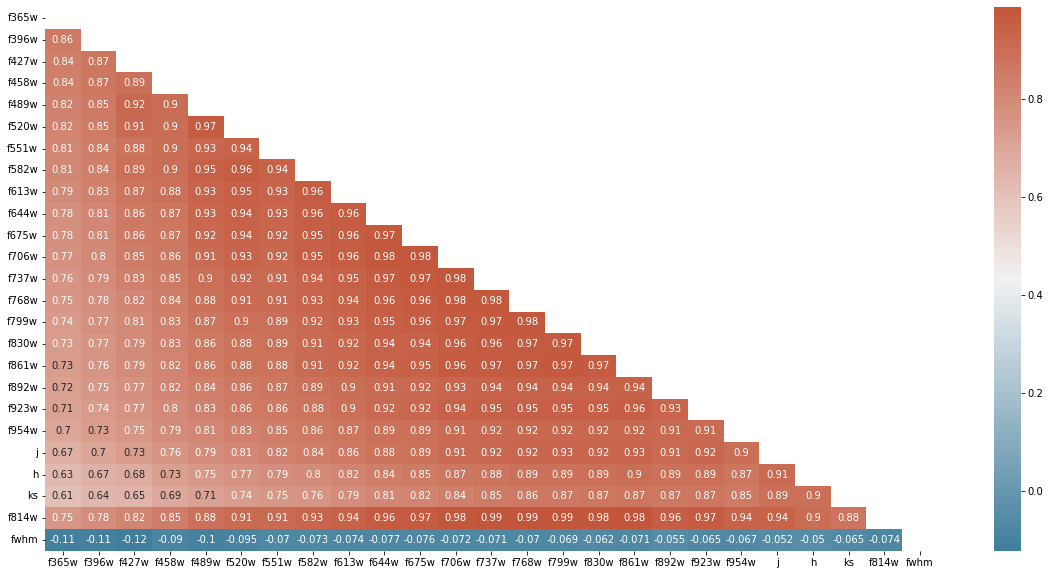

In [15]:
fcor=f1.drop(["id",'g/s','stellar_flag'],axis=1)
# Correlation between different variables
#
corr = fcor.corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(20, 10))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [712]:
f2=f1.copy(deep=True)

f2=f2[f2['f814w']<=22.5]


X=f2.drop(["id",'g/s','stellar_flag','f923w','f892w','f861w','f830w','f799w','f768w','f737w','f706w','f675w','f644w','f613w','f489w'],axis=1)
y=f2['g/s']

In [713]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

# XGboost

In [768]:
XGC=xgc()
XGC.fit(x_train,y_train)
predict=XGC.predict_proba(x_test)

In [769]:
predict=pd.DataFrame(data=predict)
predict=predict[1].values
auc_score=roc_auc_score(y_test,predict)
auc_score

0.9955564591078068

# CNN

In [703]:
f2=f1.copy(deep=True)
f2=f2[f2['f814w']<=22.5]

X=f2.drop(["id",'g/s','stellar_flag','f923w','f892w','f861w','f830w','f799w','f768w','f737w','f706w','f675w','f644w','f613w','f489w'],axis=1).values
y=f2['g/s'].values

X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

x_test.shape

(1165, 13)

In [704]:
x_train.shape

(6598, 13)

In [705]:
trainX = x_train.reshape(6598,13,1)           
x_train = trainX / 255.0
testX = x_test.reshape(1165, 13,1)
x_test = testX / 255.0

In [706]:
model=Sequential()
model.add(Convolution2D(32,kernel_size=(5, 1), input_shape=(13,1,1),activation= 'LeakyReLU' ))
model.add(MaxPool2D(pool_size=(3,1)))
model.add(Convolution2D(32,kernel_size=(3, 1),activation= 'LeakyReLU' ))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Convolution2D(64,kernel_size=(1, 1),activation= 'LeakyReLU' ))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate=0.03),metrics=["accuracy"])


In [707]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

checkpoint= ModelCheckpoint("model_checkpoint.h5",save_best_only=True)
early_stopping = EarlyStopping( patience=250, restore_best_weights=True)

In [708]:
training_history=model.fit(x_train,y_train,epochs=1000,batch_size=500,verbose=0,validation_data=[x_test,y_test],callbacks=[checkpoint,early_stopping])

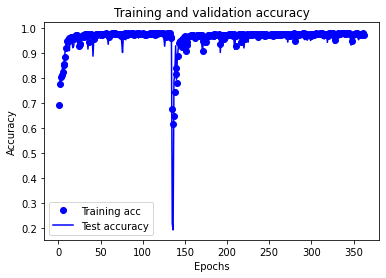

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [709]:
training_info=training_history.history
plot_training(training_info)
training_info.keys()

In [710]:
predict=model.predict(x_test)
auc_score=roc_auc_score(y_test,predict)
auc_score

37/37 [==============================] - 0s 1ms/step


0.996801148433351

therefore we can see that nearly 10-12 narrow bands can be removed to get even better prediction.These bands are highly correlated with F814w(correlation coefficient >0.95), therefore only one is enough. also from the ranking of features from randomforest and ada boost we can conclude that most of these 20 narrow bands or (flux vs wavelength graph) do not possess much different characterstics for star and galaxy. theres only (may be) a little difference which CNN captured very successfully

# Therefore we can see that CNN is giving best performance with least overfitting

# classifying by gradually adding features for F814<22.5

In [490]:
f3=f1.copy(deep=True)

f3=f3[f3['f814w']<=22.5]

X=f3.drop(["id",'g/s','stellar_flag'],axis=1)
y=f3['g/s']

c=X.columns
X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
X=pd.DataFrame(data=X)
for i in range(25):
 X.rename(columns={i:c[i]},inplace=True)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

In [491]:
score_1=[]
predicted_class_1=[]

for i in (0,3,4,5):
    if i==0: 
        k=3
    else: 
        k=5
    model=Sequential()
    model.add(Convolution2D(32,kernel_size=(k, 1), input_shape=(20+i,1,1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(3,1)))
    model.add(Convolution2D(32,kernel_size=(3, 1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(2,1)))
    model.add(Convolution2D(64,kernel_size=(2, 1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate=0.03),metrics=["accuracy"])

    checkpoint= ModelCheckpoint("model_checkpoint.h5",save_best_only=True)
    early_stopping = EarlyStopping( patience=250, restore_best_weights=True)

    x_train_new=x_train.iloc[:,0:20+i].values
    x_test_new=x_test.iloc[:,0:20+i].values
    y_train_new=y_train.values
    y_test_new=y_test.values

    trainX = x_train_new.reshape(6598,20+i,1)
    trainX = trainX / 255.0
    testX = x_test_new.reshape(1164,20+i,1)
    testX= testX / 255.0
    
    
    
    model.fit(trainX,y_train_new,epochs=1000,batch_size=500,verbose=0,validation_data=[testX,y_test_new],callbacks=[checkpoint,early_stopping])

    predict=model.predict(testX)
    score_1.append(roc_auc_score(y_test_new,predict))
    predict=pd.DataFrame(predict,columns=['pred_class']) 
    predict.loc[predict["pred_class"]<0.5, "pred_class"] = 0
    predict.loc[predict["pred_class"]>0.5, "pred_class"] = 1
    predicted_class_1.append(predict)
    


37/37 [==============================] - 0s 2ms/step


In [492]:
score_1

[0.9832174389272438, 0.9883870485926713, 0.98746182952735, 0.9878684280403611]

# classifying by gradually adding features for F814<26

# XGboost

In [632]:
f2_2=f1.copy(deep=True)
f2_2=f2_2[f2_2['f814w']<=26]

X=f2_2.drop(["id",'g/s','stellar_flag'],axis=1)
y=f2_2['g/s']

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

In [633]:
score_xg_2=[]
predicted_class_xg_2=[]

for i in (0,3,4,5):
    if i==0: 
        k=3
    else: 
        k=5

    x_train_new=x_train.iloc[:,0:20+i]
    x_test_new=x_test.iloc[:,0:20+i]
    
    
    XGC=xgc(gamma= 0.2, learning_rate= 0.3, max_depth= 6, n_estimators =80, reg_alpha= 1, scale_pos_weight= 1)
    XGC.fit(x_train_new,y_train)
    predict=XGC.predict_proba(x_test_new)
    predict=pd.DataFrame(data=predict)
    predict=predict[1].values
   

    score_xg_2.append(roc_auc_score(y_test,predict))
    predict=pd.DataFrame(predict,columns=['pred_class']) 
    predict.loc[predict["pred_class"]<0.5, "pred_class"] = 0
    predict.loc[predict["pred_class"]>0.5, "pred_class"] = 1
    predicted_class_xg_2.append(predict)

In [634]:
score_xg_2

[0.9506701845970675,
 0.9596784837881591,
 0.9610158899475004,
 0.9748835662009314]

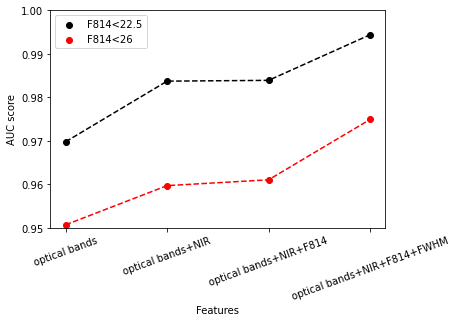

In [635]:
result_1=pd.DataFrame({'information used':['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],'F814<22.5':score_xg,'F814<26':score_xg_2})
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_xg,color="black",alpha=1,label="F814<22.5")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_xg,color="black",alpha=1,ls='dashed')
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_xg_2,color="red",alpha=1,label="F814<26")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_xg_2,color="red",alpha=1,ls='dashed')
plt.ylim(ymin=0.95,ymax=1)
plt.ylabel('AUC score')
plt.xlabel('Features')
plt.xticks(rotation=20)
plt.legend()
plt.show()

In [636]:
result_1

,information used,F814<22.5,F814<26
0,optical bands,0.969766,0.950670
1,optical bands+NIR,0.983703,0.959678
2,optical bands+NIR+F814,0.983885,0.961016
3,optical bands+NIR+F814+FWHM,0.994366,0.974884


# CNN

In [615]:
f4=f1.copy(deep=True)

f4=f4[f4['f814w']<=26]

X=f4.drop(["id",'g/s','stellar_flag'],axis=1)
y=f4['g/s']

c=X.columns
X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
X=pd.DataFrame(data=X)
for i in range(25):
 X.rename(columns={i:c[i]},inplace=True)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

In [616]:
score_2=[]
predicted_class_2=[]

for i in (0,3,4,5):
    if i==0: 
        k=3
    else: 
        k=5
    model=Sequential()
    model.add(Convolution2D(32,kernel_size=(k, 1), input_shape=(20+i,1,1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(3,1)))
    model.add(Convolution2D(32,kernel_size=(3, 1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(2,1)))
    model.add(Convolution2D(64,kernel_size=(2, 1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate=0.03),metrics=["accuracy"])

    checkpoint= ModelCheckpoint("model_checkpoint.h5",save_best_only=True)
    early_stopping = EarlyStopping( patience=250, restore_best_weights=True)

    x_train_new=x_train.iloc[:,0:20+i].values
    x_test_new=x_test.iloc[:,0:20+i].values
    y_train_new=y_train.values
    y_test_new=y_test.values

    trainX = x_train_new.reshape(x_train_new.shape[0],20+i,1)
    trainX = trainX / 255.0
    testX = x_test_new.reshape(x_test_new.shape[0],20+i,1)
    testX= testX / 255.0
    
    
    
    model.fit(trainX,y_train_new,epochs=1000,batch_size=500,verbose=0,validation_data=[testX,y_test_new],callbacks=[checkpoint,early_stopping])

    predict=model.predict(testX)
    score_2.append(roc_auc_score(y_test_new,predict))
    predict=pd.DataFrame(predict,columns=['pred_class']) 
    predict.loc[predict["pred_class"]<0.5, "pred_class"] = 0
    predict.loc[predict["pred_class"]>0.5, "pred_class"] = 1
    predicted_class_2.append(predict)

150/150 [==============================] - 0s 2ms/step


In [617]:
score_2

[0.9598502051228178, 0.9616482285092434, 0.9587734113419584, 0.962227367128092]

# now classifying objects for various ranges of F814W

CNN

In [493]:
score_814=[]
FPS_rate=[]
TPS_rate=[]

for i,j in zip([22.5,23,24,25,26],[0,22.5,23,24,0]):
    
    f5=f1.copy()
    f5=f5[(f5['f814w']<=i)&(f5['f814w']>j)]

    X=f5.drop(["id",'g/s','stellar_flag'],axis=1)
    y=f5['g/s']
    c=X.columns
    X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
    X=pd.DataFrame(data=X)
    for i in range(25):
       X.rename(columns={i:c[i]},inplace=True)
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)
    
    
    model=Sequential()
    model.add(Convolution2D(16,kernel_size=(5, 1), input_shape=(25,1,1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(3,1)))
    model.add(Convolution2D(32,kernel_size=(3, 1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(2,1)))
    model.add(Convolution2D(64,kernel_size=(2, 1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate=0.03),metrics=["accuracy"])

    checkpoint= ModelCheckpoint("model_checkpoint.h5",save_best_only=True)
    early_stopping = EarlyStopping( patience=250, restore_best_weights=True)

    x_train_new=x_train.values
    x_test_new=x_test.values
    y_train_new=y_train.values
    y_test_new=y_test.values
    
    len_train=x_train_new.shape[0]
    len_test=x_test_new.shape[0]

    trainX = x_train_new.reshape(len_train,25,1)
    trainX = trainX / 255.0
    testX = x_test_new.reshape(len_test,25,1)
    testX= testX / 255.0
    
    
    
    model.fit(trainX,y_train_new,epochs=1000,batch_size=500,verbose=0,validation_data=[testX,y_test_new],callbacks=[checkpoint,early_stopping])

    predict=model.predict(testX)
    score_814.append(roc_auc_score(y_test_new,predict))
    false_positive_rate,true_positive_rate,thresholds= roc_curve(y_test,predict) 
    FPS_rate.append(false_positive_rate)
    TPS_rate.append(true_positive_rate)

    

150/150 [==============================] - 0s 1ms/step


In [494]:
score_814

[0.9855574548592672,
 0.9024133307795441,
 0.8903618861947118,
 0.735934065934066,
 0.9575942581773026]

# RESULTS

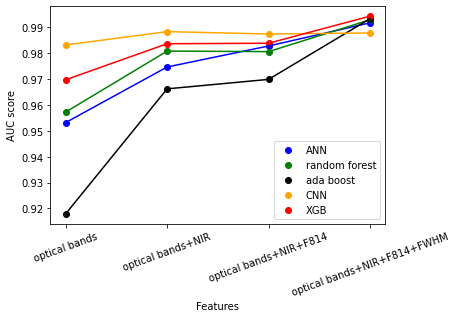

In [612]:
data_0=pd.DataFrame(data={"features":['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],"ANN":score_ann,"Random Forest":score_rf,"Ada boost":score_ada,"CNN":score_1,"XG boost":score_xg})
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_ann,color="blue",alpha=1,label="ANN")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_ann,color="blue",alpha=1)
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_rf,color="green",alpha=1,label="random forest")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_rf,color="green",alpha=1)
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_ada,color="black",alpha=1,label="ada boost")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_ada,color="black",alpha=1)
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_1,color="orange",alpha=1,label="CNN")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_1,color="orange",alpha=1)
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_xg,color="red",alpha=1,label="XGB")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_xg,color="red",alpha=1)
plt.ylabel('AUC score')
plt.xlabel('Features')
plt.xticks(rotation=20)
plt.legend()
plt.show()

In [613]:
data_0

,features,ANN,Random Forest,Ada boost,CNN,XG boost
0,optical bands,0.953212,0.957266,0.917911,0.983217,0.969766
1,optical bands+NIR,0.974704,0.980848,0.966248,0.988387,0.983703
2,optical bands+NIR+F814,0.982823,0.980649,0.969908,0.987462,0.983885
3,optical bands+NIR+F814+FWHM,0.991781,0.992963,0.993387,0.987868,0.994366


Auc score for different no. of features using CNN

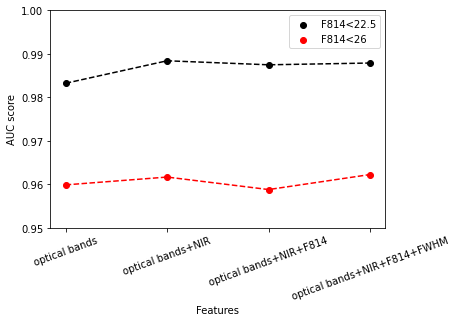

In [618]:
result_1=pd.DataFrame({'information used':['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],'F814<22.5':score_1,'F814<26':score_2})
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_1,color="black",alpha=1,label="F814<22.5")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_1,color="black",alpha=1,ls='dashed')
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_2,color="red",alpha=1,label="F814<26")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_2,color="red",alpha=1,ls='dashed')
plt.ylim(ymin=0.95,ymax=1)
plt.ylabel('AUC score')
plt.xlabel('Features')
plt.xticks(rotation=20)
plt.legend()
plt.show()

In [619]:
result_1

,information used,F814<22.5,F814<26
0,optical bands,0.983217,0.959850
1,optical bands+NIR,0.988387,0.961648
2,optical bands+NIR+F814,0.987462,0.958773
3,optical bands+NIR+F814+FWHM,0.987868,0.962227


Roc curve for different ranges of F814 using CNN

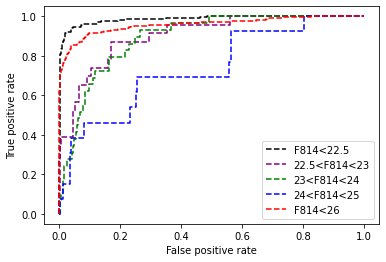

In [590]:
result_2=pd.DataFrame({'F814':["F814<22.5","22.5<F814<23","23<F814<24","24<F814<25","F814<26"],'AUC score':score_814})
plt.plot(FPS_rate[0],TPS_rate[0],color="black",alpha=1,ls='dashed',label="F814<22.5")
plt.plot(FPS_rate[1],TPS_rate[1],color="purple",alpha=1,ls='dashed',label="22.5<F814<23")
plt.plot(FPS_rate[2],TPS_rate[2],color="green",alpha=1,ls='dashed',label="23<F814<24")
plt.plot(FPS_rate[3],TPS_rate[3],color="blue",alpha=1,ls='dashed',label="24<F814<25")
plt.plot(FPS_rate[4],TPS_rate[4],color="red",alpha=1,ls='dashed',label="F814<26")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.legend()
plt.show()

In [591]:
result_2

,F814,AUC score
0,F814<22.5,0.985557
1,22.5<F814<23,0.902413
2,23<F814<24,0.890362
3,24<F814<25,0.735934
4,F814<26,0.957594


now comparing alhambras stellar flag and our predicted data

In [665]:
f4=f1.copy(deep=True)
f4=f4[f4['f814w']<=26]
X=f4.drop(['g/s'],axis=1)
y=f4['g/s']
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)
x_test=pd.DataFrame(data=x_test['stellar_flag'],columns=['stellar_flag'])
x_test=x_test.reset_index()
x_test.drop('index',axis=1,inplace=True)
all_class=predicted_class_2[3].merge(x_test,left_index=True,right_index=True)
all_class.drop(all_class[all_class['stellar_flag']==0.5].index,inplace=True)
all_class.loc[all_class["stellar_flag"]<0.5, "stellar_flag"] = 0
all_class.loc[all_class["stellar_flag"]>0.5, "stellar_flag"] = 1



accuracy

In [666]:
from sklearn.metrics import accuracy_score
accuracy_score(all_class['stellar_flag'],all_class['pred_class'])

0.9574283231972198

XGboost

In [663]:
f4=f1.copy(deep=True)
f4=f4[f4['f814w']<=26]
X=f4.drop(['g/s'],axis=1)
y=f4['g/s']
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)
x_test=pd.DataFrame(data=x_test['stellar_flag'],columns=['stellar_flag'])
x_test=x_test.reset_index()
x_test.drop('index',axis=1,inplace=True)
all_class=predicted_class_xg_2[3].merge(x_test,left_index=True,right_index=True)
all_class.drop(all_class[all_class['stellar_flag']==0.5].index,inplace=True)
all_class.loc[all_class["stellar_flag"]<0.5, "stellar_flag"] = 0
all_class.loc[all_class["stellar_flag"]>0.5, "stellar_flag"] = 1

In [664]:
from sklearn.metrics import accuracy_score
accuracy_score(all_class['stellar_flag'],all_class['pred_class'])

0.9782797567332754

therefore we can see that alhambras classification and our classification is pretty much same

# via ranking of features we can see that 20 narrow band magnitudes are not a good classifier of star and galaxy even after making them good learners by ada boost..although CNN was able to capture the relation very perfectly but it will be interesting to see if colors are more useful than magnitudes as they are often use to get the surface temperatures and other magnitudes of stars.

In [786]:
f2=f1.copy(deep=True)
f2=f2[f2['f814w']<=22.5]
X=f2.drop(["id",'g/s','stellar_flag'],axis=1)
y=f2['g/s']

for i in range(19):
    X[str(i)]=-X.iloc[:,i+1]+X.iloc[:,i]

X['j-h']=X['j']-X['h']
X['h-ks']=X['h']-X['ks']


for i in (X.columns):
   if i!='f814w': 
      X.drop(i,axis=1,inplace=True)
   else:
      break  


X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

x_test.shape

(1165, 23)

In [788]:
trainX = x_train.reshape(6598,23,1)           
x_train = trainX / 255.0
testX = x_test.reshape(1165, 23,1)
x_test = testX / 255.0

In [789]:
model=Sequential()
model.add(Convolution2D(18,kernel_size=(5, 1), input_shape=(23,1,1),activation= 'LeakyReLU' ))
model.add(MaxPool2D(pool_size=(3,1)))
model.add(Convolution2D(32,kernel_size=(3, 1),activation= 'LeakyReLU' ))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Convolution2D(64,kernel_size=(1, 1),activation= 'LeakyReLU' ))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate=0.03),metrics=["accuracy"])

In [790]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

checkpoint= ModelCheckpoint("model_checkpoint.h5",save_best_only=True)
early_stopping = EarlyStopping( patience=250, restore_best_weights=True)

In [791]:
training_history=model.fit(x_train,y_train,epochs=1000,batch_size=500,verbose=0,validation_data=[x_test,y_test],callbacks=[checkpoint,early_stopping])

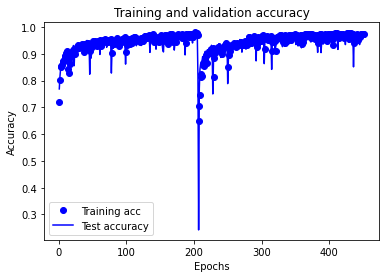

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [792]:
training_info=training_history.history
plot_training(training_info)
training_info.keys()

In [793]:
predict=model.predict(x_test)
auc_score=roc_auc_score(y_test,predict)
auc_score

37/37 [==============================] - 0s 3ms/step


0.9944237918215613

x-------------------------x

classifying by gradually adding features for F814w<22.5

In [904]:

f2=f1.copy(deep=True)
f2=f2[f2['f814w']<=22.5]
X=f2.drop(["id",'g/s','stellar_flag'],axis=1)
y=f2['g/s']

for i in range(19):
    X[str(i)]=-X.iloc[:,i+1]+X.iloc[:,i]

X['j-h']=X['j']-X['h']
X['h-ks']=X['h']-X['ks']

for i in (X.columns):
   if i!='f814w': 
      X.drop(i,axis=1,inplace=True)
   else:
      break 

X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
X=pd.DataFrame(X)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

x_test.shape

(1165, 23)

In [905]:
x_train.shape

(6598, 23)

In [906]:
score_1=[]
predicted_class_1=[]

for i in (0,2,3,4):
    if i==0: 
        k=4
    else: 
        k=5
    model=Sequential()
    model.add(Convolution2D(18,kernel_size=(k, 1), input_shape=(19+i,1,1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(3,1)))
    model.add(Convolution2D(32,kernel_size=(3, 1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(2,1)))
    model.add(Convolution2D(64,kernel_size=(1, 1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate=0.03),metrics=["accuracy"])

    checkpoint= ModelCheckpoint("model_checkpoint.h5",save_best_only=True)
    early_stopping = EarlyStopping( patience=250, restore_best_weights=True)
    
   
    x_train_new=x_train.iloc[:,0:19+i].values
    x_test_new=x_test.iloc[:,0:19+i].values
    y_train_new=y_train.values
    y_test_new=y_test.values

    trainX = x_train_new.reshape(6598,19+i,1)
    trainX = trainX / 255.0
    testX = x_test_new.reshape(1165,19+i,1)
    testX= testX / 255.0
    
    
    
    model.fit(trainX,y_train_new,epochs=1000,batch_size=500,verbose=0,validation_data=[testX,y_test_new],callbacks=[checkpoint,early_stopping])

    predict=model.predict(testX)
    score_1.append(roc_auc_score(y_test_new,predict))
    predict=pd.DataFrame(predict,columns=['pred_class']) 
    predict.loc[predict["pred_class"]<0.5, "pred_class"] = 0
    predict.loc[predict["pred_class"]>0.5, "pred_class"] = 1
    predicted_class_1.append(predict)

37/37 [==============================] - 0s 2ms/step


In [907]:
score_1

[0.9955606080722251,
 0.9951042219861923,
 0.9911730781996814,
 0.9898972716409985]

classifying by gradually adding features for F814w<26

In [908]:
f2=f1.copy(deep=True)
f2=f2[f2['f814w']<=26]
X=f2.drop(["id",'g/s','stellar_flag'],axis=1)
y=f2['g/s']

for i in range(19):
    X[str(i)]=-X.iloc[:,i+1]+X.iloc[:,i]

X['j-h']=X['j']-X['h']
X['h-ks']=X['h']-X['ks']


for i in (X.columns):
   if i!='f814w': 
      X.drop(i,axis=1,inplace=True)
   else:
      break  

temp_cols=X.columns.tolist()
new_cols=temp_cols[1:] + temp_cols[0:1]
X=X[new_cols]

temp_cols=X.columns.tolist()
new_cols=temp_cols[1:] + temp_cols[0:1]
X=X[new_cols]

X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
X=pd.DataFrame(X)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

x_test.shape

(4780, 23)

In [909]:
x_train.shape

(27082, 23)

In [910]:
score_2=[]
predicted_class_2=[]

for i in (0,2,3,4):
    if i==0: 
        k=3
    else: 
        k=5
    model=Sequential()
    model.add(Convolution2D(18,kernel_size=(k, 1), input_shape=(19+i,1,1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(3,1)))
    model.add(Convolution2D(32,kernel_size=(3, 1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(2,1)))
    model.add(Convolution2D(64,kernel_size=(1, 1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate=0.03),metrics=["accuracy"])

    checkpoint= ModelCheckpoint("model_checkpoint.h5",save_best_only=True)
    early_stopping = EarlyStopping( patience=250, restore_best_weights=True)
    
   
    x_train_new=x_train.iloc[:,0:19+i].values
    x_test_new=x_test.iloc[:,0:19+i].values
    y_train_new=y_train.values
    y_test_new=y_test.values

    trainX = x_train_new.reshape(x_train_new.shape[0],19+i,1)
    trainX = trainX / 255.0
    testX = x_test_new.reshape(x_test_new.shape[0],19+i,1)
    testX= testX / 255.0
    
    
    
    model.fit(trainX,y_train_new,epochs=1000,batch_size=500,verbose=0,validation_data=[testX,y_test_new],callbacks=[checkpoint,early_stopping])

    predict=model.predict(testX)
    score_2.append(roc_auc_score(y_test_new,predict))
    predict=pd.DataFrame(predict,columns=['pred_class']) 
    predict.loc[predict["pred_class"]<0.5, "pred_class"] = 0
    predict.loc[predict["pred_class"]>0.5, "pred_class"] = 1
    predicted_class_2.append(predict)

150/150 [==============================] - 0s 2ms/step


In [911]:
score_2

[0.9415123868322733,
 0.9400052795892696,
 0.9593343677018433,
 0.9510479715333168]

x----------------------------x


now classifying for various ranges of F814w

In [857]:
score_814=[]
FPS_rate=[]
TPS_rate=[]

for i,j in zip([22.5,23,24,25,26],[0,22.5,23,24,0]):
    
    f2=f1.copy(deep=True)
    f2=f2[(f2['f814w']<=i)&(f2['f814w']>j)]
    X=f2.drop(["id",'g/s','stellar_flag'],axis=1)
    y=f2['g/s']

    for i in range(19):
        X[str(i)]=-X.iloc[:,i+1]+X.iloc[:,i]

    X['j-h']=X['j']-X['h']
    X['h-ks']=X['h']-X['ks']


    for i in (X.columns):
      if i!='f814w': 
           X.drop(i,axis=1,inplace=True)
      else:
           break  

    temp_cols=X.columns.tolist()
    new_cols=temp_cols[1:] + temp_cols[0:1]
    X=X[new_cols]

    temp_cols=X.columns.tolist()
    new_cols=temp_cols[1:] + temp_cols[0:1]
    X=X[new_cols]

    X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
    X=pd.DataFrame(X)
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

       
    
    
    model=Sequential()
    model.add(Convolution2D(18,kernel_size=(5, 1), input_shape=(23,1,1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(3,1)))
    model.add(Convolution2D(32,kernel_size=(3, 1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Convolution2D(64,kernel_size=(1, 1),activation= 'LeakyReLU' ))
    model.add(MaxPool2D(pool_size=(1,1)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1,activation="sigmoid"))
    model.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate=0.03),metrics=["accuracy"])

    checkpoint= ModelCheckpoint("model_checkpoint.h5",save_best_only=True)
    early_stopping = EarlyStopping( patience=250, restore_best_weights=True)

    x_train_new=x_train.values
    x_test_new=x_test.values
    y_train_new=y_train.values
    y_test_new=y_test.values
    
    len_train=x_train_new.shape[0]
    len_test=x_test_new.shape[0]

    trainX = x_train_new.reshape(len_train,23,1)
    trainX = trainX / 255.0
    testX = x_test_new.reshape(len_test,23,1)
    testX= testX / 255.0
    
    
    
    model.fit(trainX,y_train_new,epochs=1000,batch_size=500,verbose=0,validation_data=[testX,y_test_new],callbacks=[checkpoint,early_stopping])

    predict=model.predict(testX)
    score_814.append(roc_auc_score(y_test_new,predict))
    false_positive_rate,true_positive_rate,thresholds= roc_curve(y_test,predict) 
    FPS_rate.append(false_positive_rate)
    TPS_rate.append(true_positive_rate)

150/150 [==============================] - 0s 2ms/step


In [858]:
score_814

[0.9883040693043016,
 0.9060524803677457,
 0.7892043377604485,
 0.7607692307692308,
 0.9516183557311828]

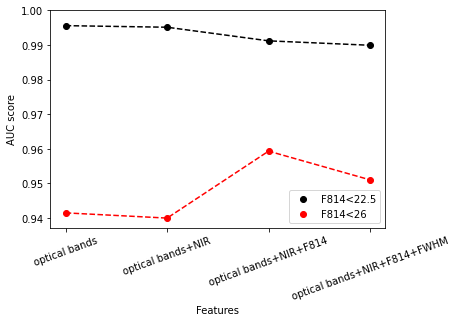

In [912]:
result_1=pd.DataFrame({'information used':['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],'F814<22.5':score_1,'F814<26':score_2})
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_1,color="black",alpha=1,label="F814<22.5")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_1,color="black",alpha=1,ls='dashed')
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_2,color="red",alpha=1,label="F814<26")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_2,color="red",alpha=1,ls='dashed')
plt.ylim(ymax=1)
plt.ylabel('AUC score')
plt.xlabel('Features')
plt.xticks(rotation=20)
plt.legend()
plt.show()

In [842]:
result_1

,information used,F814<22.5,F814<26
0,optical bands,0.994283,0.951770
1,optical bands+NIR,0.994536,0.936749
2,optical bands+NIR+F814,0.995386,0.958924
3,optical bands+NIR+F814+FWHM,0.994602,0.953886


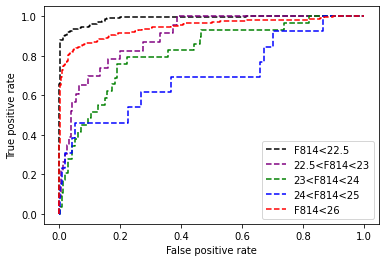

In [843]:
result_2=pd.DataFrame({'F814':["F814<22.5","22.5<F814<23","23<F814<24","24<F814<25","F814<26"],'AUC score':score_814})
plt.plot(FPS_rate[0],TPS_rate[0],color="black",alpha=1,ls='dashed',label="F814<22.5")
plt.plot(FPS_rate[1],TPS_rate[1],color="purple",alpha=1,ls='dashed',label="22.5<F814<23")
plt.plot(FPS_rate[2],TPS_rate[2],color="green",alpha=1,ls='dashed',label="23<F814<24")
plt.plot(FPS_rate[3],TPS_rate[3],color="blue",alpha=1,ls='dashed',label="24<F814<25")
plt.plot(FPS_rate[4],TPS_rate[4],color="red",alpha=1,ls='dashed',label="F814<26")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.legend()
plt.show()

In [844]:
result_2

,F814,AUC score
0,F814<22.5,0.988491
1,22.5<F814<23,0.898487
2,23<F814<24,0.818521
3,24<F814<25,0.700714
4,F814<26,0.944958


comparing our pridctions with ALHAMBRA stellar flags

In [867]:
f4=f1.copy(deep=True)
f4=f4[f4['f814w']<26]
X=f4.drop(['g/s'],axis=1)
y=f4['g/s']
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)
x_test=pd.DataFrame(data=x_test['stellar_flag'],columns=['stellar_flag'])
x_test=x_test.reset_index()
x_test.drop('index',axis=1,inplace=True)
all_class=predicted_class_2[3].merge(x_test,left_index=True,right_index=True)
all_class.drop(all_class[all_class['stellar_flag']==0.5].index,inplace=True)
all_class.loc[all_class["stellar_flag"]<0.5, "stellar_flag"] = 0
all_class.loc[all_class["stellar_flag"]>0.5, "stellar_flag"] = 1

all_class

,pred_class,stellar_flag
4,0.0,0.0
15,0.0,0.0
19,0.0,0.0
31,0.0,0.0
34,0.0,0.0
...,...,...
4767,0.0,0.0
4771,1.0,1.0
4774,0.0,0.0
4777,0.0,0.0


In [868]:
from sklearn.metrics import accuracy_score
accuracy_score(all_class['stellar_flag'],all_class['pred_class'])

0.9626411815812337

# ranking of features

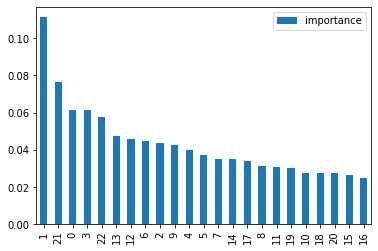

In [253]:
f2=f1.copy(deep=True)
f2=f2[f2['f814w']<=22.5]
X=f2.drop(["id",'g/s','stellar_flag'],axis=1)
y=f2['g/s']

for i in range(19):
    X[str(i)]=-X.iloc[:,i+1]+X.iloc[:,i]

X['j-h']=X['j']-X['h']
X['h-ks']=X['h']-X['ks']

for i in (X.columns):
   if i!='f814w': 
      X.drop(i,axis=1,inplace=True)
   else:
      break 

X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
X=pd.DataFrame(X)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)





ada=AdaBoostClassifier(n_estimators=100,base_estimator=(DecisionTreeClassifier(max_depth=4))).fit(x_train,y_train)
feature_importances = pd.DataFrame(ada.feature_importances_, index =x_train.columns,  columns=['importance']).sort_values('importance', ascending=False)
feature_importances.plot.bar()    # plotting ranking based on their importance   
plt.show()

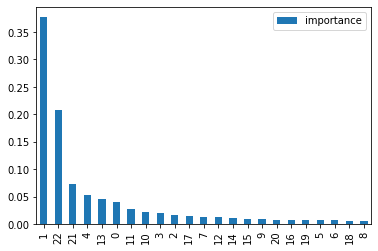

In [255]:
f2=f1.copy(deep=True)
f2=f2[f2['f814w']<=22.5]
X=f2.drop(["id",'g/s','stellar_flag'],axis=1)
y=f2['g/s']

for i in range(19):
    X[str(i)]=-X.iloc[:,i+1]+X.iloc[:,i]

X['j-h']=X['j']-X['h']
X['h-ks']=X['h']-X['ks']

for i in (X.columns):
   if i!='f814w': 
      X.drop(i,axis=1,inplace=True)
   else:
      break 

X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
X=pd.DataFrame(X)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)



rf=RandomForestClassifier(min_samples_split=2,n_jobs=-1).fit(x_train,y_train)
feature_importances = pd.DataFrame(rf.feature_importances_, index =x_train.columns,  columns=['importance']).sort_values('importance', ascending=False)
feature_importances.plot.bar()    # plotting ranking based on their importance   
plt.show()

in these ranking of features 0: f365-f396, 1: f396-f427, 3:f458-f459, 13: f768-f799, 21: f814w, 22: FWHM 

correlation of features

In [259]:
f1.columns

Index(['id', 'f365w', 'f396w', 'f427w', 'f458w', 'f489w', 'f520w', 'f551w',
       'f582w', 'f613w', 'f644w', 'f675w', 'f706w', 'f737w', 'f768w', 'f799w',
       'f830w', 'f861w', 'f892w', 'f923w', 'f954w', 'j', 'h', 'ks', 'f814w',
       'fwhm', 'stellar_flag', 'g/s'],
      dtype='object')

In [869]:
f2=f1.copy(deep=True)
f2=f2[f2['f814w']<=22.5]
X=f2.drop(["id",'g/s','stellar_flag'],axis=1)
y=f2['g/s']

for i in range(19):
    X[str(i)]=-X.iloc[:,i+1]+X.iloc[:,i]

X['j-h']=X['j']-X['h']
X['h-ks']=X['h']-X['ks']

for i in (X.columns):
   if i!='f814w': 
      X.drop(i,axis=1,inplace=True)
   else:
      break 

X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
X=pd.DataFrame(X)
X=X[[0,1,3,13,21,22]]
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

In [870]:
print(x_train.shape,x_test.shape)

(6598, 6) (1165, 6)


In [871]:
x_train=x_train.values
x_test=x_test.values


trainX = x_train.reshape(6598,6,1)           
x_train = trainX / 255.0
testX = x_test.reshape(1165, 6,1)
x_test = testX / 255.0

In [872]:
model=Sequential()
model.add(Convolution2D(32,kernel_size=(3, 1), input_shape=(6,1,1),activation= 'LeakyReLU' ))
model.add(MaxPool2D(pool_size=(2,1)))
model.add(Convolution2D(64,kernel_size=(2, 1),activation= 'LeakyReLU' ))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer= Adam(learning_rate=0.03),metrics=["accuracy"])

checkpoint= ModelCheckpoint("model_checkpoint.h5",save_best_only=True)
early_stopping = EarlyStopping( patience=250, restore_best_weights=True)

In [873]:
training_history=model.fit(x_train,y_train,epochs=1000,batch_size=500,verbose=0,validation_data=[x_test,y_test],callbacks=[checkpoint,early_stopping])

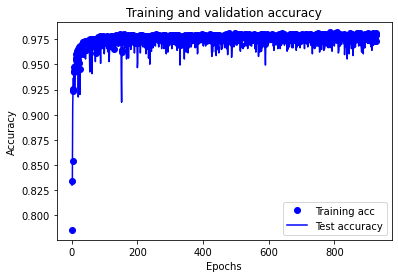

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [874]:
training_info=training_history.history
plot_training(training_info)
training_info.keys()

In [875]:
predict=model.predict(x_test)
auc_score=roc_auc_score(y_test,predict)
auc_score

37/37 [==============================] - 0s 989us/step


0.9949839020180562

x-----------------------------x

XGBoost

In [883]:
f2=f1.copy(deep=True)
f2=f2[f2['f814w']<=22.5]
X=f2.drop(["id",'g/s','stellar_flag'],axis=1)
y=f2['g/s']

for i in range(19):
    X[str(i)]=-X.iloc[:,i+1]+X.iloc[:,i]

X['j-h']=X['j']-X['h']
X['h-ks']=X['h']-X['ks']


for i in (X.columns):
   if i!='f814w': 
      X.drop(i,axis=1,inplace=True)
   else:
      break  


X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
X=pd.DataFrame(X)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)


print(x_test.shape,x_train.shape)

(1165, 23) (6598, 23)


In [878]:
param_grid={
    'n_estimators':[80,100,120],
    'max_depth':[4,6,8],
    'learning_rate':[0.1,0.3],
    'gamma':[0,0.1,0.2],
    'scale_pos_weight':[1,3.5],
    'reg_alpha':[0,1,5]
}

cv=GridSearchCV(estimator=xgc(),param_grid=param_grid,cv=5,n_jobs=-1)
cv.fit(x_train,y_train)
print(cv.best_params_)

{'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 80, 'reg_alpha': 0, 'scale_pos_weight': 3.5}


In [879]:
XGC=xgc(gamma= 0, learning_rate= 0.3, max_depth= 6, n_estimators =80, reg_alpha= 0, scale_pos_weight= 3.5)
XGC.fit(x_train,y_train)
predict=XGC.predict_proba(x_test)

predict=pd.DataFrame(data=predict)
predict=predict[1].values
auc_score=roc_auc_score(y_test,predict)
auc_score

0.9953407129580457

for different features, f814w <22.5

In [900]:
score_xg=[]
predicted_class_xg=[]

for i in (0,2,3,4):
    if i==0: 
        k=3
    else: 
        k=5

    x_train_new=x_train.iloc[:,0:19+i]
    x_test_new=x_test.iloc[:,0:19+i]
    
    
    XGC=xgc(gamma= 0.2, learning_rate= 0.3, max_depth= 6, n_estimators =80, reg_alpha= 1, scale_pos_weight= 3.5)
    XGC.fit(x_train_new,y_train)
    predict=XGC.predict_proba(x_test_new)
    predict=pd.DataFrame(data=predict)
    predict=predict[1].values
   

    score_xg.append(roc_auc_score(y_test,predict))
    predict=pd.DataFrame(predict,columns=['pred_class']) 
    predict.loc[predict["pred_class"]<0.5, "pred_class"] = 0
    predict.loc[predict["pred_class"]>0.5, "pred_class"] = 1
    predicted_class_xg.append(predict)

In [901]:
score_xg

[0.9942121946362188,
 0.9942412373871482,
 0.9928056956983538,
 0.9954402881040891]

for different ranges

In [902]:
score_814_xg=[]
FPS_rate_xg=[]
TPS_rate_xg=[]

for i,j in zip([22.5,23,24,25,26],[0,22.5,23,24,0]):
   
    f2=f1.copy(deep=True)
    f2=f2[(f2['f814w']<=i)&(f2['f814w']>j)]
    X=f2.drop(["id",'g/s','stellar_flag'],axis=1)
    y=f2['g/s']

    for i in range(19):
        X[str(i)]=-X.iloc[:,i+1]+X.iloc[:,i]

    X['j-h']=X['j']-X['h']
    X['h-ks']=X['h']-X['ks']


    for i in (X.columns):
      if i!='f814w': 
           X.drop(i,axis=1,inplace=True)
      else:
           break  

    temp_cols=X.columns.tolist()
    new_cols=temp_cols[1:] + temp_cols[0:1]
    X=X[new_cols]

    temp_cols=X.columns.tolist()
    new_cols=temp_cols[1:] + temp_cols[0:1]
    X=X[new_cols]

    X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
    X=pd.DataFrame(X)
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

    
    XGC=xgc(gamma= 0.2, learning_rate= 0.3, max_depth= 6, n_estimators =80, reg_alpha= 1, scale_pos_weight= 3.5)
    XGC.fit(x_train,y_train)
    predict=XGC.predict_proba(x_test)
    predict=pd.DataFrame(data=predict)
    predict=predict[1].values
    
    score_814_xg.append(roc_auc_score(y_test,predict))
    false_positive_rate,true_positive_rate,thresholds= roc_curve(y_test,predict) 
    FPS_rate_xg.append(false_positive_rate)
    TPS_rate_xg.append(true_positive_rate)

In [903]:
score_814_xg

[0.995066881306426,
 0.9303773223520398,
 0.8711100280248568,
 0.7913186813186813,
 0.9714767496047041]

for f814w<=26

In [913]:
f2=f1.copy(deep=True)
f2=f2[f2['f814w']<=26]
X=f2.drop(["id",'g/s','stellar_flag'],axis=1)
y=f2['g/s']

for i in range(19):
    X[str(i)]=-X.iloc[:,i+1]+X.iloc[:,i]

X['j-h']=X['j']-X['h']
X['h-ks']=X['h']-X['ks']


for i in (X.columns):
   if i!='f814w': 
      X.drop(i,axis=1,inplace=True)
   else:
      break  


X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
X=pd.DataFrame(X)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)


print(x_test.shape,x_train.shape)

(4780, 23) (27082, 23)


In [918]:
score_xg_2=[]
predicted_class_xg_2=[]

for i in (0,2,3,4):
    if i==0: 
        k=3
    else: 
        k=5

    x_train_new=x_train.iloc[:,0:19+i]
    x_test_new=x_test.iloc[:,0:19+i]
    
    
    XGC=xgc()
    XGC.fit(x_train_new,y_train)
    predict=XGC.predict_proba(x_test_new)
    predict=pd.DataFrame(data=predict)
    predict=predict[1].values
   

    score_xg_2.append(roc_auc_score(y_test,predict))
    predict=pd.DataFrame(predict,columns=['pred_class']) 
    predict.loc[predict["pred_class"]<0.5, "pred_class"] = 0
    predict.loc[predict["pred_class"]>0.5, "pred_class"] = 1
    predicted_class_xg_2.append(predict)

In [919]:
score_xg_2

[0.9694127265038075,
 0.9664389170377194,
 0.9717131189712344,
 0.9782230410972925]

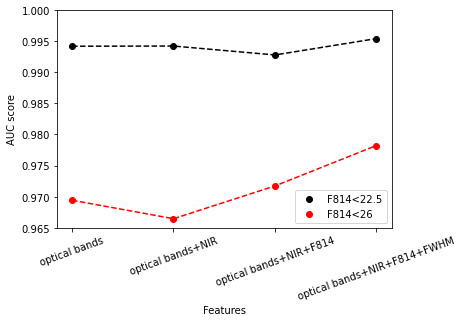

In [920]:
result_1=pd.DataFrame({'information used':['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],'F814<22.5':score_xg,'F814<26':score_xg_2})
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_xg,color="black",alpha=1,label="F814<22.5")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_xg,color="black",alpha=1,ls='dashed')
plt.scatter(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_xg_2,color="red",alpha=1,label="F814<26")
plt.plot(['optical bands','optical bands+NIR','optical bands+NIR+F814','optical bands+NIR+F814+FWHM'],score_xg_2,color="red",alpha=1,ls='dashed')
plt.ylim(ymax=1)
plt.ylabel('AUC score')
plt.xlabel('Features')
plt.xticks(rotation=20)
plt.legend()
plt.show()

In [921]:
result_1

,information used,F814<22.5,F814<26
0,optical bands,0.994212,0.969413
1,optical bands+NIR,0.994241,0.966439
2,optical bands+NIR+F814,0.992806,0.971713
3,optical bands+NIR+F814+FWHM,0.995440,0.978223


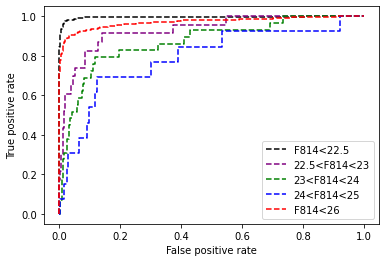

In [922]:
result_2=pd.DataFrame({'F814':["F814<22.5","22.5<F814<23","23<F814<24","24<F814<25","F814<26"],'AUC score':score_814_xg})
plt.plot(FPS_rate_xg[0],TPS_rate_xg[0],color="black",alpha=1,ls='dashed',label="F814<22.5")
plt.plot(FPS_rate_xg[1],TPS_rate_xg[1],color="purple",alpha=1,ls='dashed',label="22.5<F814<23")
plt.plot(FPS_rate_xg[2],TPS_rate_xg[2],color="green",alpha=1,ls='dashed',label="23<F814<24")
plt.plot(FPS_rate_xg[3],TPS_rate_xg[3],color="blue",alpha=1,ls='dashed',label="24<F814<25")
plt.plot(FPS_rate_xg[4],TPS_rate_xg[4],color="red",alpha=1,ls='dashed',label="F814<26")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.legend()
plt.show()

In [923]:
result_2

,F814,AUC score
0,F814<22.5,0.995067
1,22.5<F814<23,0.930377
2,23<F814<24,0.871110
3,24<F814<25,0.791319
4,F814<26,0.971477


In [924]:
f4=f1.copy(deep=True)
f4=f4[f4['f814w']<26]
X=f4.drop(['g/s'],axis=1)
y=f4['g/s']
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)
x_test=pd.DataFrame(data=x_test['stellar_flag'],columns=['stellar_flag'])
x_test=x_test.reset_index()
x_test.drop('index',axis=1,inplace=True)
all_class=predicted_class_xg_2[3].merge(x_test,left_index=True,right_index=True)
all_class.drop(all_class[all_class['stellar_flag']==0.5].index,inplace=True)
all_class.loc[all_class["stellar_flag"]<0.5, "stellar_flag"] = 0
all_class.loc[all_class["stellar_flag"]>0.5, "stellar_flag"] = 1

In [925]:
from sklearn.metrics import accuracy_score
accuracy_score(all_class['stellar_flag'],all_class['pred_class'])

0.9869678540399652

after reducing features

In [927]:
f2=f1.copy(deep=True)
f2=f2[f2['f814w']<=22.5]
X=f2.drop(["id",'g/s','stellar_flag'],axis=1)
y=f2['g/s']

for i in range(19):
    X[str(i)]=-X.iloc[:,i+1]+X.iloc[:,i]

X['j-h']=X['j']-X['h']
X['h-ks']=X['h']-X['ks']

for i in (X.columns):
   if i!='f814w': 
      X.drop(i,axis=1,inplace=True)
   else:
      break 

X=MinMaxScaler(feature_range=(0,255)).fit_transform(X)
X=pd.DataFrame(X)
X=X[[0,1,3,13,21,22]]
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=1)

In [951]:
XGC=xgc(gamma= 1, learning_rate= 0.03, max_depth= 8, n_estimators =100, reg_alpha= 1, scale_pos_weight= 3.5)
XGC.fit(x_train,y_train)
predict=XGC.predict_proba(x_test)

predict=pd.DataFrame(data=predict)
predict=predict[1].values
auc_score=roc_auc_score(y_test,predict)
auc_score

0.9946167186670207